# K-Means clustering from scratch
Author: [Ryan Parker](https://github.com/rparkr)  
In this notebook, I implement a vectorized version of the k-means clustering algorithm and use it to create color palettes from an input image.

K-Means is algorithm that finds groups, or _clusters_, in a dataset by:
1. choosing $k$ starting data points as the cluster centers
2. assigning all remaining data points to a cluster based on the cluster center nearest to them
3. computing the new cluster center as the mean of all the points in that cluster
4. repeating steps 2-3 until convergence: when points are reassigned after successive iterations

**What is it useful for?**  
Clustering algorithms are _unsupervised_: there is no label, or target, to predict. Instead, the algorithm seeks to find a pattern in the data, which can help group data into simlar categories. Some example uses of clustering include:
- find related items (products, articles, observations) to an item of interest
- group text documents, like comments or reviews, into categories (topic modeling)
- segment customers
- compress images by reducing the colors used
- categorize transactions

|            Demo data           |           Color palettes          |
|:------------------------------:|:---------------------------------:|
|<img src="../images/kmeans.png">|  <img src="../images/kmeans.png"> |

# Setup
Import required packages and create a sample dataset.

I implement the algorithm using only `numpy`, but I use `matplotlib` for visualization, `sklearn` for creating a sample dataset, `requests` for downloading images, and `pillow` for loading images into `numpy` arrays.

In [147]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle  # for drawing boxes on plots
import matplotlib.colors as mcolors  # for accessing color names and choosing color palettes
import numpy as np
from PIL import Image
import requests
from sklearn.datasets import make_classification

## Create sample dataset
This dataset will be used to demonstrate the clustering algorithm

X: (1000, 20)
y: (1000,)


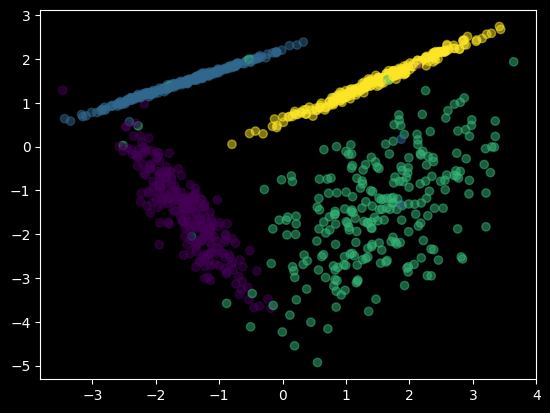

In [171]:
X, y = make_classification(n_samples=1000, n_classes=4, n_clusters_per_class=1,
                           shuffle=False, class_sep=1.5)

print(f"X: {X.shape}\ny: {y.shape}")

plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5)
plt.show()

# K-Means algorithm
In this section, I define a class that implements the k-means clustering algorithm.

In [ ]:
class KMeans():
    def __init__(self, k: int=5, n_rounds: int=10, random_state=None) -> None:
        '''Create an object to perform K-Means clustering on a dataset.
        
        # Parameters
        `k`: int, default=5
            The number of clusters to create.
        `n_rounds`: int, default=10
            The number of rounds for the clustering algorithm to run, each
            starting with randomly-chosen initial centers. The best-performing
            run will be returned, as determined by the set of clusters that
            minimizes the average distance between points and cluster centers.
        `random_state`: int, default=None
            If set, this value will be used as the seed when initializing
            cluster centers.
        
        # Attributes
        `labels_`: the cluster assignments for each record in `data`, as
            determined by the best fit after `n_rounds`.
        `centers_`: the centers of the clusters; as determined by the best fit
            after running `n_rounds` of the algorithm.
        `distances_`: the average distance between points and their assigned
            cluster centers.
        `hist_`: a dictionary storing the results from all training iterations
        '''
        # Store arguments passed on instantiation
        self.__dict__.update(locals())
        self.hist_ = {0: {
            'labels': {0: []},
            'centers': {0: []},
            'distances': {0: []}
            } 
        }

        self.labels_ = np.array([])
        self.centers_ = np.array([])
        self.distances_ = np.array([])


    def fit(self, data: np.ndarray) -> None:
        '''Assign cluster labels to a dataset.

        After fitting the model, access the labels through
        the `labels_` attribute, numpy integer array.
        
        # Parameters
        `data`: `numpy.ndarray`
            The input array, to be used for grouping into clusters.
        '''
        for round in range(self.n_rounds):
            if self.random_state:
                # Increment the random state each iteration to change starting
                # point selection while maintaining deterministic behavior
                self.random_state += 1
            rng = np.random.default_rng(seed=self.random_state)
            # ========================================
            # Step 1: select starting clusters
            # ========================================
            # Sample one point for each of the cluster centers
            centers = rng.choice(data, size=self.k, replace=False, shuffle=False)
            
            iter = 0
            converged = False
            while not converged:
                self.hist_[round]['centers'][iter].append(centers)

                # ========================================
                # Step 2: compute distance to each cluster
                # ========================================
                # Add a cluster dimension to the data array to store the distance of each
                # cluster center at each of the data points' dimensions.
                # Add a row dimension to the transposed centers array to broadcast down
                # the rows of the data array.
                distances = (data[..., np.newaxis] - centers.T[np.newaxis, ...])**2
                # .sum(axis=1) finds the distance from each point to each cluster center, returns a 2d array
                # .argmin(axis=1) finds the closest cluster center, returns a 1d array
                labels = distances.sum(axis=1).argmin(axis=1)
                self.hist_[round]['labels'][iter].append(labels)
                

                # Create a boolean one-hot-encoding of the closest cluster center for each point
                indices = np.eye(k, dtype='bool')[labels]
                print(f"Shape of indices: {indices.shape}")

                # Index the X array to compute the new mean based the cluster assignments
                # cluster_assignments is a 3d array: (rows, columns, clusters), where dim 3 is
                # 0s where the cluster was not assigned and equal to the column values at the
                # assigned cluster.
                cluster_assignments = (X[..., np.newaxis] * indices[:, np.newaxis, :])
                centers = cluster_assignments.mean(axis=0, where=(cluster_assignments != 0)).T
                print(f"Shape of cluster centers: {centers.shape}")


                self.hist_[round]['distances'][iter].append(distances**(0.5))
                
                print(f"Shape of distances array: {distances.shape}")
                print(f"Shape of labels array: {labels.shape}")
                iter += 1

# K-Means, step by step
This section shows how K-Means is built out, step by step, with comments explaining the vectorized operations.

In [185]:
k = 4  # Set the number of clusters

# Sample one point for each of the cluster centers
rng = np.random.default_rng()
centers = rng.choice(X, size=k, replace=False, shuffle=False)

print(f"Shape of cluster centers: {centers.shape}")
print(f"Transpose and add a row dimension for broadcasting: {centers.T[np.newaxis, :, :].shape}")

Shape of cluster centers: (4, 20)
Transpose and add a row dimension for broadcasting: (1, 20, 4)


In [194]:
# Add a cluster dimension (dim 3) to the X array to store the distance of each
# cluster center to the data point at each of the point's dimensions.
# Add a row dimension (dim 1) to the transposed centers array to broadcast down
# the rows of the X array.
distances = (X[..., np.newaxis] - centers.T[np.newaxis, ...])**2
# .sum(axis=1) finds the distance from each point to each cluster center, returns a 2d array
# .argmin(axis=1) finds the closest cluster center, returns a 1d array
labels = distances.sum(axis=1).argmin(axis=1)

print(f"Shape of distances array: {distances.shape}")
print(f"Shape of labels array: {labels.shape}")

Shape of distances array: (1000, 20, 4)
Shape of labels array: (1000,)


The cell below uses vectorized operations to compute the new cluster means by indexing into the `X` array and computing the mean for each cluster across all the samples (rows) in `X`.

This is a loop equivalent:

```python
centers = []
for i in range(k):
    centers.append(X[labels==i].mean(axis=0))
```

In [195]:
# Create a boolean one-hot-encoding of the closest cluster center for each point
indices = np.eye(k, dtype='bool')[labels]
print(f"Shape of indices: {indices.shape}")

# Index the X array to compute the new mean based the cluster assignments
# cluster_assignments is a 3d array: (rows, columns, clusters), where dim 3 is
# 0s where the cluster was not assigned and equal to the column values at the
# assigned cluster.
cluster_assignments = (X[..., np.newaxis] * indices[:, np.newaxis, :])
centers = cluster_assignments.mean(axis=0, where=(cluster_assignments != 0)).T
print(f"Shape of cluster centers: {centers.shape}")

Shape of indices: (1000, 4)
Shape of cluster centers: (4, 20)


## Visualize cluster assignments

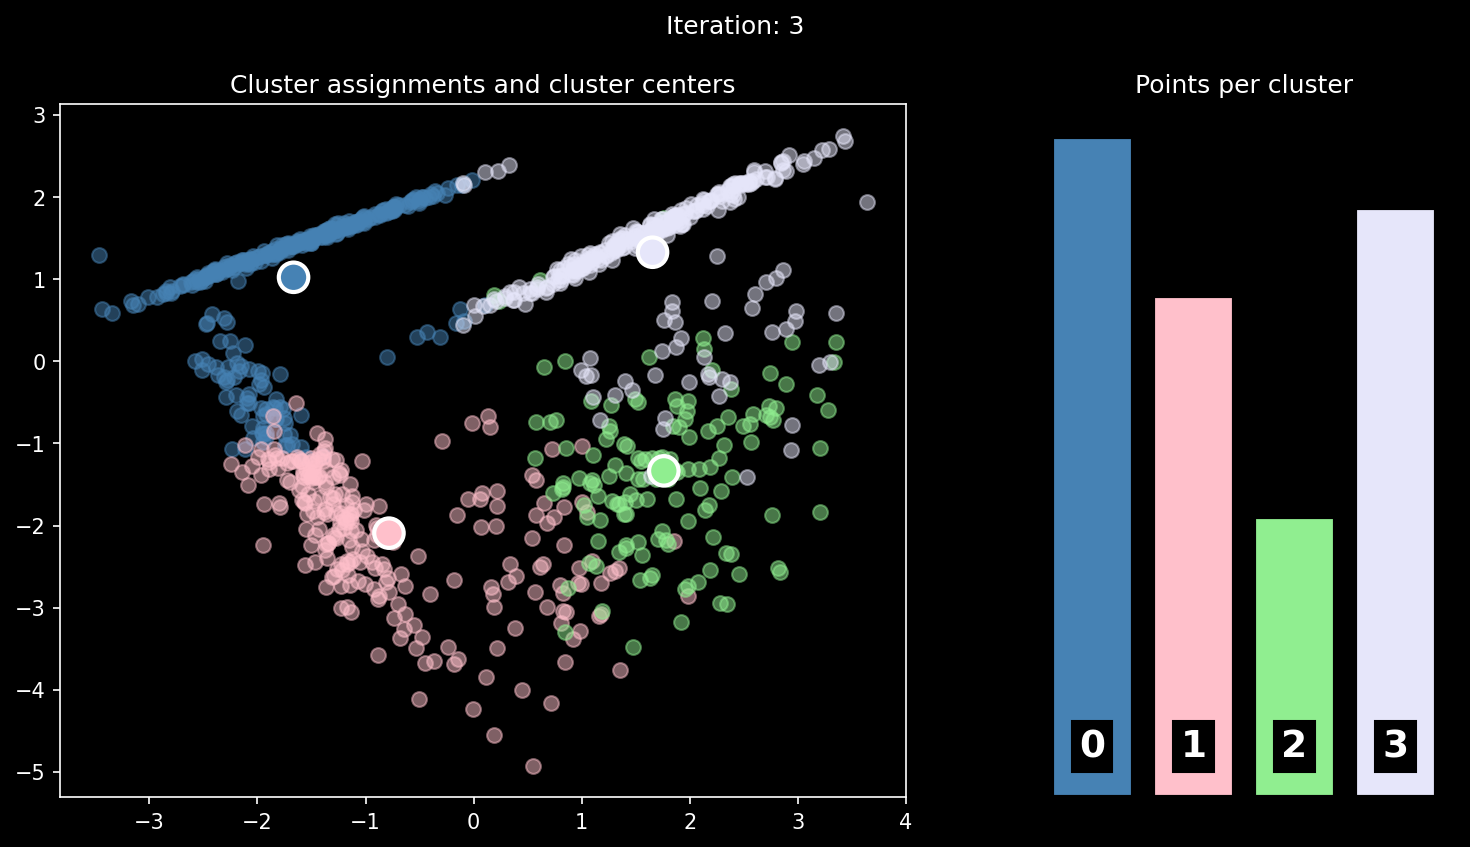

In [196]:
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

step_num = 3  # the iteration for the algorithm

# Select k random colors for plotting
rng = np.random.default_rng()
colors = rng.choice(list(mcolors.CSS4_COLORS.keys()), size=k, replace=False)
colors = ['steelblue', 'pink', 'lightgreen', 'lavender']

counts = np.eye(k, dtype='int')[labels].sum(axis=0)
for i in range(k):
    # Plot the points and their categories
    row_mask = (labels == i)
    axs[0].scatter(X[row_mask, 0], X[row_mask, 1], s=50, color=colors[i], alpha=0.5, label=i)
    # Plot the distribution of labels
    axs[1].bar(x=i, height=counts[i], color=colors[i], edgecolor='k', linewidth=2, label=i)
    y_midpoint = (len(labels) / k) / 2
    x_midpoint = k / 2
    axs[1].add_patch(Rectangle((i - x_midpoint/10, y_midpoint/10), x_midpoint/5, y_midpoint/5, color='black'))
    axs[1].text(x=i, y=y_midpoint/5, s=i, fontweight='bold', fontsize='18',
            ha='center', va='center', color='white')

# Plot the center points on top of everything else
axs[0].scatter(centers[:, 0], centers[:, 1], color=colors, edgecolor='white',
               s=200, linewidth=2, alpha=1.0, label="centers")

axs[0].set_title('Cluster assignments and cluster centers')
axs[1].set_title('Points per cluster')
axs[1].axis('off')
# plt.legend()
fig.suptitle(f"Iteration: {step_num:,.0f}")
plt.show()

# Utilities

## Check if arrays are broadcastable
While implementing the K-means algorithm, I often reshaped arrays to get them to align so operations would be broadcastable. I found [a helpful one-liner on Stack Overflow that checks whether arrays are broadcastable](https://stackoverflow.com/questions/47243451/checking-if-two-arrays-are-broadcastable-in-python/47244284#47244284). The function below uses that one-liner.

In [28]:
def can_broadcast(a, b):
    '''Check whether arrays a and b can be broadcast together.'''
    return all((m == n) or (m == 1) or (n == 1) 
               for m, n in zip(a.shape[::-1], b.shape[::-1]))

In [39]:
a = np.array([[1, 1, 1], [2, 2, 2]])
b = np.array([3, 3, 3]).reshape((1, 1, -1))
print("a:", a.shape)
print(a)
print("\nb:", b.shape)
print(b)

print(f"\nCan a and b be broadcast? {can_broadcast(a, b)}")

print(f"a * b: {(a * b).shape}\n{a * b}")

a: (2, 3)
[[1 1 1]
 [2 2 2]]

b: (1, 1, 3)
[[[3 3 3]]]

Can a and b be broadcast? True
a * b: (1, 2, 3)
[[[3 3 3]
  [6 6 6]]]
